<img style="float:right; max-width:300px" src="imgs/time series.jpg" width="60%" />

# Analiza vremenske serije
Vremenska serija je kolekcija observacija $x_t$ uređenih po vremenu. Na osnovu nezavisne promenljive $x$, koja predstavlja vreme, želimo da predvidimo zavisnu promenljivu $y$. Razlika u odnosu na dosadašnju linearnu regresiju je što podaci nisu linearni, i želimo da koristimo informacije o prethodnim observacijama ($y_t$ ne zavisi samo od trenutnog $x_t$, već i od prethodnih observacija $x_{t-1}$, ...). Predviđamo tačke van poznatog opsega, pa koristimo ekstrapolaciju.

Za početak, učitavamo neophodne pakete i skup podataka:

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

df = pd.read_csv('data/airline-passengers.csv', sep=',')
print(df.dtypes)
df.head()

Month         object
Passengers     int64
dtype: object


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Konvertujemo kolonu `Month` iz tipa `object` u tip `datetime` i postavljamo je kao indeks (radi lakše manipulacije podacima). Zatim izdvajamo vreme (u mesecima) u nezavisnu promenljivu $x$, a broj putnika koji su leteli u svakom mesecu u zavisnu promenljivu $y$.

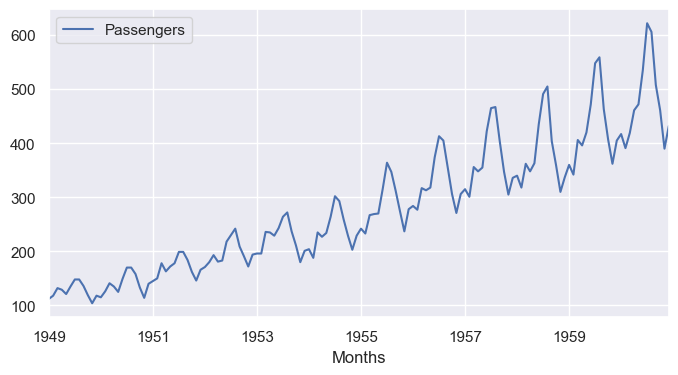

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

df.plot();
# ekvivalentno sa:
x, y = df.index, df['Passengers']
plt.plot(x, y); plt.xlabel('Months');

## Autokorelacija
Autokorelacija služi da proverimo da li postoji šablon u podacima.
Da bismo mogli da modelujemo vremensku seriju, mora postojati autokorelacija.
Pozitivna autokorelacija znači da vrednosti $y$ opadaju (ili rastu) zajedno, dok negativna autokorelacija znači da vrednosti $y$ opadaju (ili rastu) suprotno.
Ako nema autokorelacije, to znači da se vrednosti menjaju na slučajan način kroz vreme i da ne možemo pronaći šablon u podacima ➡️ tada problem ne možemo rešiti algoritmima vremenske serije.

### Autokorelogram
Autokorelaciju tumačimo preko autokorelograma.
Autokorelogram (eng. *autocorrelation function* ili *ACF*) je grafik autokorelacije. Koristimo funkciju `plot_acf()` da nacrtamo grafik.
Na x-osi je vremenski razmak $k$ između dve observacije. Na y-osi je koeficijent autokorelacije za vremenski razmak $k$.

Vrednosti unutar osenčenog dela su beznačajne ➡️ sa 95% pouzdanosti nema autokorelacije za trenutno $k$.
Vrednosti van osenčenog dela su značajne, odnosno postoji autokorelacija (koliko je jaka, to govori koeficijent autokorelacije).
Ukoliko na grafiku dobijemo da su (skoro) sve vrednosti unutar osenčenog dela ➡️ onda nema autokorelacije; verovatno ne postoji šablon u podacima već su podaci šum.

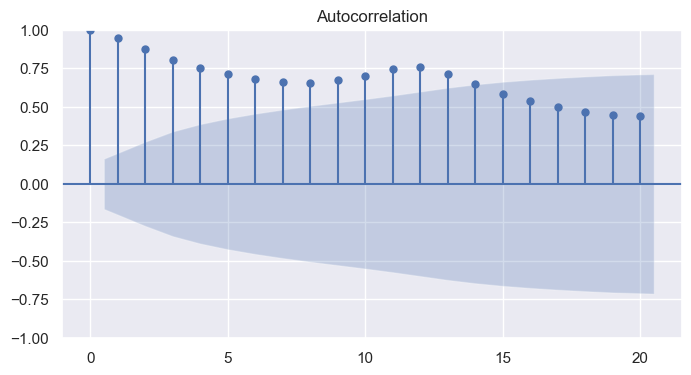

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Passengers'], lags=20)
plt.show()

<img style="float:right; max-width:400px" src="imgs/acf_pacf.png" width="60%" />

Tumačenje: Sa grafika vidimo da posle $k=14$ ne postoji autokorelacija; vrednosti su beznačajne. Visoka ACF vrednost za $k=2$ ukazuje na jak uticaj pretprošlog meseca na trenutni. Npr. ako broj putnika u januaru raste (opada) onda broj putnika u martu raste (opada) zbog pozitivne autokorelacije. Na osnovu broja putnika u januaru možemo predvideti broj putnika u martu.

Moguće je da broj putnika u januaru nema direktan uticaj na mart, već na februar koji utiče na mart - ovo je indirektan uticaj.
**Autokorelacija meri direktan i indirektan uticaj** pretprošlog meseca na trenutni.
Međutim, ako nas zanima direktan uticaj *broja putnika u januaru* na *broj putnika u martu* (preskačemo februar), koristimo *parcijalnu autokorelaciju*.

### Parcijalna autokorelacija
Autokorelacija meri direktan i indirektan uticaj, dok parcijalna autokorelacija meri samo direktan uticaj (eng. *partial autocorrelation function - PACF*). Da izmerimo samo direktan uticaj koristimo *PACF*.

**Tumačenje:** Sa sledeceg grafika vidimo da samo nekoliko vrednosti za $k$ ima veliku PACF vrednost. Za k=2, primećujemo značajnu vrednost, ali gotovo na granici, što ukazuje na relativno slab direktni uticaj preprošlog meseca na trenutni mesec.

**ACF vs PACF:** S obzirom na veliku ACF vrednost za $k=2$ i manju PACF vrednost ➡️ pretprošli mesec ima jak indirektan, ali slab direktni uticaj na broj putnika u trenutnom mesecu. Visoka ACF vrednost za $k=2$ sugeriše da možemo predviđati broj putnika u martu, ako znamo broj putnika u januaru i februaru. S druge strane, značajna PACF vrednost za $k=2$ ukazuje da možemo predviđati broj putnika u martu na osnovu broja putnika u januaru (preskačemo februaru). Ipak, s obzirom da je PACF vrednost na granici, predikcije za mart samo na osnovu januara će biti manje precizne.

**PACF za analizu vs PACF za predikcije:**
PACF primenjujemo nad nestacionarnom podacima (objašnjeno u nastavku) **za analizu** vremenske serije. Nestacionarni podaci imaju komponente (trend i sezonalnost) koje indirektno utiču na vrednosti PACF. PACF ne otklanja ovaj indirektan uticaj komponenti.
PACF grafik ćemo koristi i u kontekstu **predikcije modela** (radimo u sledećem terminu), a tada ćemo PACF upotrebiti nad stacionarnim podacima i vrednosti koeficijenata će se razlikovati (PACF nad nestacionarnim podacima nema iste vrednosti kao PACF nad stacionarnim podacima).

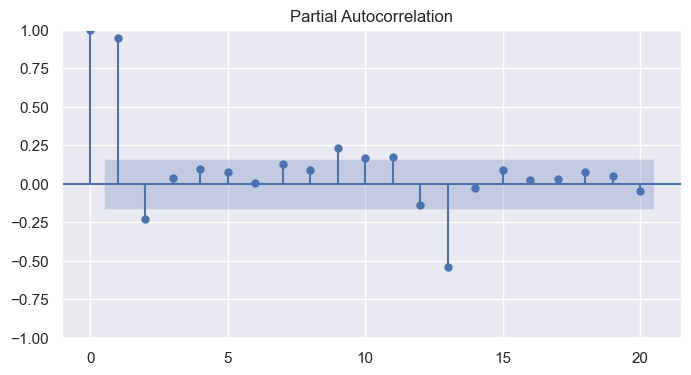

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Passengers'], lags=20)
plt.show()

<img style="float:right; max-width:400px" src="imgs/components.jpg" width="60%" />

## Komponente vremenske serije
Vremenska serija sastoji se od više komponenti (komponente - obrasci koji utiču na ponašanje vremenske serije). 
4 glavne komponente su: **trend, sezonalnost, cikličnost i reziduali (šum)**.
Da bismo analizirali vremensku seriju, razdvajamo je na komponente. 
*Napomena: cikličnost se ne pojavljuje u redovnim intervalima i oblik nije uniforman kao kod sezonalnosti, što otežava njeno detektovanje kao zasebnu komponentu. Zbog toga je često identifikujemo unutar trenda, umesto kao samostalnu komponentu.*

Da bismo seriju razdvojili na komponente, moramo znati na koji način je serija sačinjena od komponenti, tj. kako komponente međusobno deluju. Način interakcije komponenti može biti:
- aditivni model
    - podaci su dobijeni kao zbir komponenti: $𝑌_𝑡=𝑇_𝑡+𝑆_𝑡+𝐶_𝑡+𝑅_𝑡$.
    - Magnituda sezonalnosti, cikličnosti i šuma ne zavisi od trenda.
- multiplikativni model
    - podaci su dobijeni kao proizvod komponenti: $𝑌_𝑡=𝑇_𝑡∗𝑆_𝑡∗𝐶_𝑡∗𝑅_𝑡$.
    - Magnituda sezonalnosti, cikličnosti i šuma zavisi od trenda.
    
<img style="float:right; max-width:400px" src="imgs/additive vs multiplicative.png" width="60%" />

Koji model bolje opisuje podatke, utvrđujemo preko grafika, kao na slici desno.

### STL metod
Da vremensku seriju razdvojimo na komponente, koristimo **STL** metod (*Seasonal-Trend decomposition using LOESS*). **STL** metod zahteva aditivni model.

U našem primeru sa brojem putnika, sa grafika vremenske serije vidimo da se magnituda komponenti menja kako se trend menja, pa zaključujemo da imamo *multiplikativni model*. Međutim, STL metod zahteva aditivni model, pa je neophodno transformisati podatke u aditivni model. Multiplikativni model se može transformisati u aditivni logaritmovanjem: $log(𝑌_𝑡 )=log(𝑇_𝑡 )+log(𝑆_𝑡 )+log(𝐶_𝑡 )+log(𝑅_𝑡)$. *Napomena: logaritmovanje koristimo i kada podaci imaju eksponencijalan trend pa nisu jasno vidljivi.*

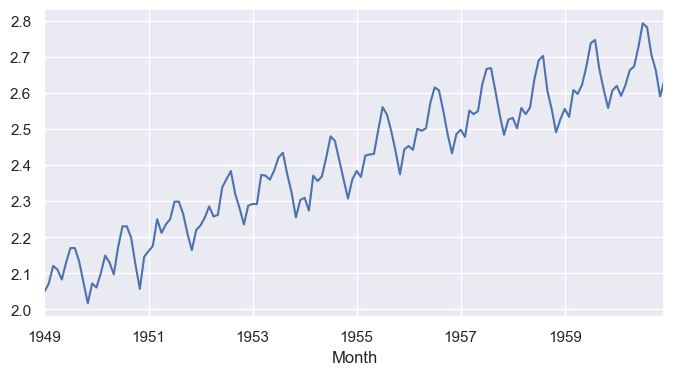

In [41]:
df['log10(Passengers)'] = np.log10(df['Passengers'])
df['log10(Passengers)'].plot();

Logaritmovanjem smo dobili nove podatke tako da magnituda sezonalnosti, cikličnosti i šuma ne zavisi od trenda ➡️ dobili smo aditivni model. 
Sada primenjujemo STL metod da vremensku seriju razdvojimo na komponente:

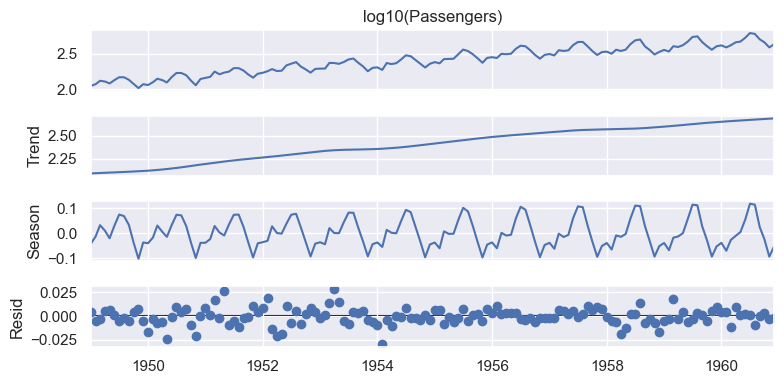

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['log10(Passengers)']).fit()
stl.plot()
plt.show()
# mogli smo i ručno preuzeti vrednosti na sledeći način:
trend, seasonal, resid = stl.trend, stl.seasonal, stl.resid

Tumačenje: Primenom STL metode rastavili smo vremensku seriju na komponente i vidimo da u podacima postoji trend i sezonalnost. 

<img style="float:right; max-width:400px" src="imgs/stationarity.png" width="40%" />

## Stacionarnost
Distribuciju opisuju statističke karakteristike (npr. **srednja vrednost, varijansa i kovarijansa**). Distribucija se ne menja kroz vreme kada su navedene statističke karakteristike konstantne. Stacionarnost znači da se distribucija ne menja kroz vreme tj. statističke karakteristike su konstantne. Za prediktivne modele (koje radimo u nastavku) neophodno je da su podaci stacionarni. Većina modela i tehnika zahteva stacionarnu vremensku seriju. Ako vremenska serija nije stacionarna, moramo je transformisati tako da dobijemo stacionarnost.

Za testiranje stacionarnosti koristimo ADF test (*Augmented Dickey–Fuller*). Sa 95% tačnosti (p-vrednost ≤ 0.05) tvrdimo da je vremenska serija stacionarna kada je ADF ≤ -2.862. Umesto ADF vrednosti možemo koristiti p-vrednost. Ako je konkretna `p-vrednost ≤ 0.05` => 95% smo sigurni da je vremenska serija stacionarna ✅.

U našem primeru sa brojem putnika, vremenska serija nije stacionarna. Proverićemo stacionarnost ADF testom u nastavku, gde vidimo da je p-vrednost velika i nismo dobili stacionarnu vremensku seriju.


adf_value=0.82, p_value=0.99
ne postoji stacionarnost


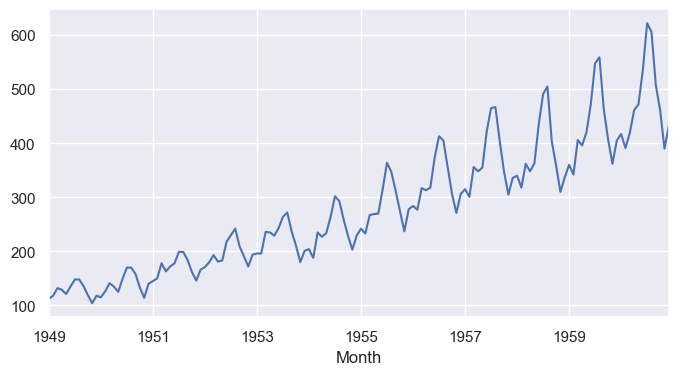

In [43]:
df['Passengers'].plot();
from statsmodels.tsa.stattools import adfuller
adf_value = adfuller(df['Passengers'])[0] 
p_value = adfuller(df['Passengers'])[1]
print(f'{adf_value=:.2f}, {p_value=:.2f}')

if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')

### Postizanje stacionarnosti
- Srednju vrednost rešavamo: 1. uklanjanjem trenda ili 2. diferenciranjem.  
- Varijansu i kovarijansu rešavamo: 1. uklanjanjem sezonalnosti ili 2. diferenciranjem ili 3.  logaritmovanjem.

*Diferenciranje - traženje izvoda za vremensku seriju.*

Naša vremenska serija ima sva 3 problema. Da bi ih rešili, za početak ćemo logaritmovati podatke (to smo već uradili pre STL metode). 
Sa grafika vidimo da smo rešili problem varijanse i kovarijanse (skoro pa je potpuno konstantno), što je odlično ✅.
Iako još uvek nije postignuta stacionarnost, vidimo da se p-vrednost smanjila, što znači da smo na dobrom putu.

adf_value=-1.72, p_value=0.42
ne postoji stacionarnost


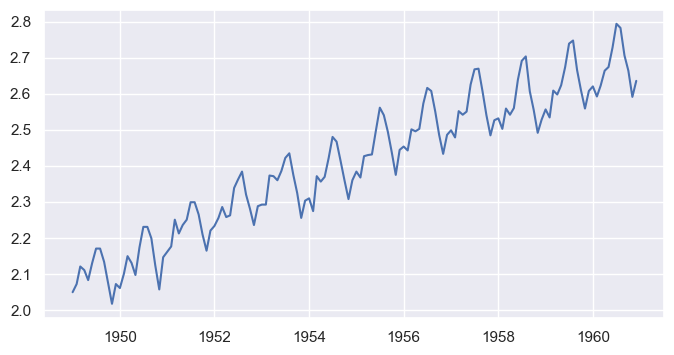

In [44]:
stationary_data = df['log10(Passengers)'].copy() # duboka kopija da ne menjamo kolonu
plt.plot(stationary_data);

adf_value = adfuller(df['log10(Passengers)'])[0] 
p_value = adfuller(df['log10(Passengers)'])[1]
print(f'{adf_value=:.2f}, {p_value=:.2f}')

if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')

Čini se da je logaritmovanje rešilo dva problema stacionarnosti - varijansu i kovarijansu. 
Fali još i konstantna srednja vrednost kako bi dobili stacionarnost, što možemo rešiti uklanjanjem trenda ili diferenciranjem.

p_value=0.03
postoji stacionarnost


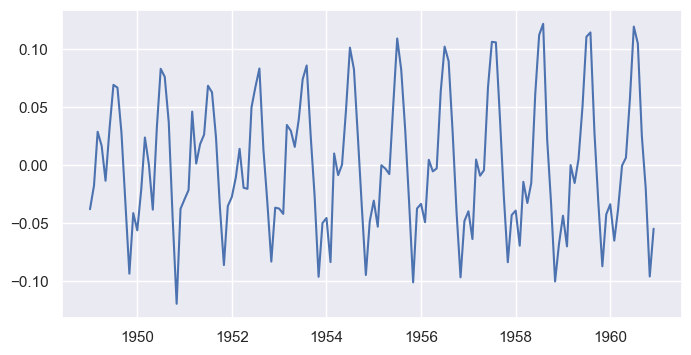

In [45]:
# 1. način - uklanjamo trend
stationary_data = df['log10(Passengers)'] - trend
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')
plt.plot(stationary_data);

Uklanjanje trenda je rešilo problem srednje vrednosti i dobili smo stacionarnost. Probaćemo sada da rešimo srednju vrednost na drugi način - diferenciranjem.

p_value=0.07
ne postoji stacionarnost


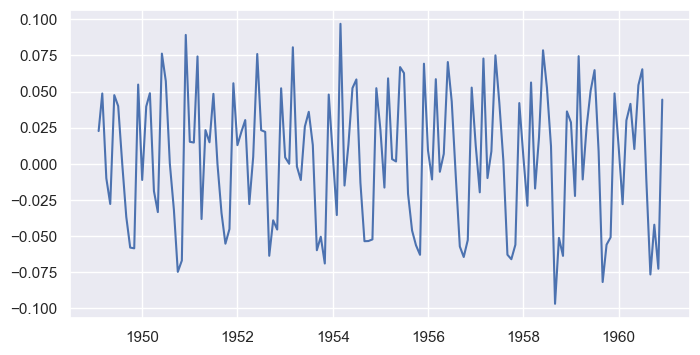

In [46]:
# 2. način - diferenciranje pozivom funkcije `diff()`
stationary_data = df['log10(Passengers)'].diff().dropna()
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')
plt.plot(stationary_data);

Iako je p-vrednost vrlo blizu praga od 5%, trenutno još uvek nema stacionarnosti nakon diferenciranja jer nije ispod praga. 
Možemo još jednom da primenimo diferenciranje:

*Napomena: u praksi uglavnom ne treba diferencirati više od 3 puta, jer će se izgubuti puno podataka.*

p_value=0.00
postoji stacionarnost


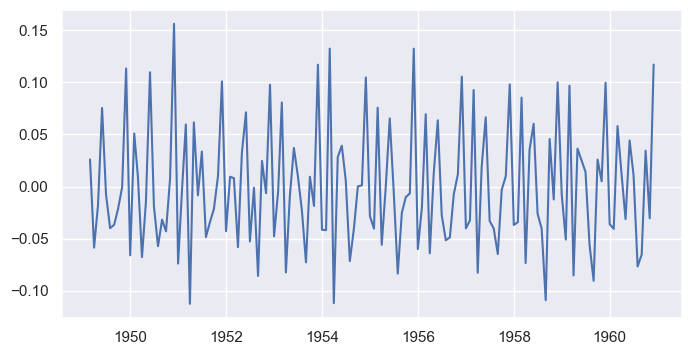

In [47]:
# 2. način - 2x diferenciranje `diff().diff()`
stationary_data = df['log10(Passengers)'].diff().diff().dropna()
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')
plt.plot(stationary_data);

## Zadaci
**TODO 1**: Učitaj vremensku seriju za broj putnika koristeći [data/airline-passengers.csv](data/airline-passengers.csv) i izdvoji podatke od 1954. do 1960. godine (ne uzimajuci ni jedan datum iz 1960). Zatim:
1. nacrtaj grafik vremenske seirje,
1. Utvrdi da li se podaci mogu modelovati kao vremenska serija,
1. Utvrdi koji prethodni meseci imaju direktan uticaj na trenutni,
1. Razdvoji vremensku seriju na komponente i nacrtaj grafik komponenti,
1. Rekonstruiši i nacrtaj originalnu vremensku seriju koristeći samo podatke o trendu, sezonalnosti i šumu.
1. Postigni stacionarnost sa sigurnošću od 99% bez upotrebe diferenciranja.